In [1]:
import yfinance as yf
import pandas as pd
end = '2023-01-31'
df = yf.download('ETH-USD', start='2022-08-01', end=end)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-01,1681.445557,1700.170898,1613.416016,1635.195801,1635.195801,16191371176
2022-08-02,1634.645874,1672.629761,1567.851074,1632.945435,1632.945435,20426082309
2022-08-03,1633.051270,1678.098267,1595.634521,1618.874512,1618.874512,16786218830
2022-08-04,1618.886719,1658.511597,1585.326538,1608.205811,1608.205811,14467440626
2022-08-05,1607.523926,1732.254639,1606.497070,1732.254639,1732.254639,18546491876
...,...,...,...,...,...,...
2023-01-26,1611.080933,1626.198242,1586.598145,1603.105957,1603.105957,8395315241
2023-01-27,1603.080078,1617.000854,1565.244995,1598.156494,1598.156494,8124465373
2023-01-28,1598.125366,1604.704102,1565.390137,1572.435059,1572.435059,5803653357


In [2]:
data = df.loc[:, ["Close"]].copy()
data.loc[:, 'Date'] = df.index
data.columns = ["y", "ds"]

In [3]:
data.columns = ["y", "ds"]
from prophet import Prophet

best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 30, 'seasonality_prior_scale': 15}

# prophet = Prophet(
#     growth='linear',
#     changepoint_prior_scale=0.5,
#     n_changepoints=50,
#     seasonality_mode='multiplicative',
#     yearly_seasonality=False,
#     weekly_seasonality=True,
#     daily_seasonality=True,
#     interval_width=0.95,
#     seasonality_prior_scale=10.0,
#     mcmc_samples=300,
#     uncertainty_samples=1000
# )
prophet = Prophet(
    changepoint_prior_scale=0.4, 
    growth='linear', 
    seasonality_prior_scale=0.3,
    seasonality_mode='multiplicative', 
    weekly_seasonality=False, 
    daily_seasonality=False,
)
# prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)

prophet.add_seasonality(name="daily", period=1, fourier_order=10)
prophet.add_seasonality(name="weekly", period=7, fourier_order=10)
prophet.add_seasonality(name="monthly", period=30, fourier_order=10)
prophet.add_seasonality(name="quarterly", period=92.25, fourier_order=10)
# prophet.add_seasonality(name="yearly", period=365, fourier_order=5)

prophet.fit(data)

20:34:01 - cmdstanpy - INFO - Chain [1] start processing
20:34:01 - cmdstanpy - INFO - Chain [1] done processing


In [4]:

future_datas = prophet.make_future_dataframe(periods=90)
predictions = prophet.predict(future_datas)

In [5]:
import matplotlib.pyplot as plt


In [6]:
filtered_data = predictions.loc[predictions['ds'] >= end]
first_day = filtered_data['ds'].iloc[0]
last_day = filtered_data['ds'].iloc[-1]
print(first_day, last_day)

2023-01-31 00:00:00 2023-04-30 00:00:00


In [7]:
test = yf.download('ETH-USD', start=first_day, end=last_day)
test


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-31,1567.419922,1598.517578,1563.804321,1586.535400,1586.535400,6585191019
2023-02-01,1586.488159,1644.727539,1566.857300,1641.792725,1641.792725,8116969489
2023-02-02,1641.365967,1704.458130,1641.322632,1643.241577,1643.241577,10558081069
2023-02-03,1642.904663,1670.696899,1634.223389,1664.745605,1664.745605,8169519805
2023-02-04,1664.472290,1690.099609,1648.189209,1667.059204,1667.059204,5843302512
...,...,...,...,...,...,...
2023-04-25,1842.204346,1877.484985,1805.322876,1866.753662,1866.753662,8677255481
2023-04-26,1866.148926,1962.567627,1792.463867,1866.564209,1866.564209,14356524696
2023-04-27,1866.693237,1936.945190,1863.147949,1908.786377,1908.786377,14008145806


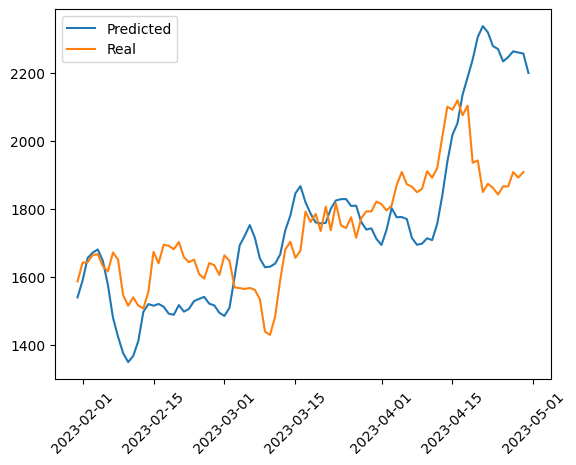

In [8]:
plt.plot(filtered_data['ds'],filtered_data["yhat"], label="Predicted")

plt.plot(test["Close"], label="Real")
plt.xticks(rotation=45)
plt.legend()
plt.show()